In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard library imports
import sys
import os
import json

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Set pandas display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

# Define file location
PY_FILE_LOC = os.getcwd()

# Project-specific utility imports
from utils.japan_admin_data import (
    prefecture_dict_jp_to_en,
    japanadmin_muni_all_jp_to_en,
)
from utils.nbutils_corr import vars_iv_rename_cols
from utils.nbutils_regression import (
    regression_analysis_yearly,
    get_pred_n_outliers_z_score,
)
from utils.nbutils_load_data import load_and_process_data, build_df_for_analysis

# Modeling imports
from sklearn.ensemble import RandomForestRegressor


In [3]:
# load the processed data
ftr_pref_muni = ["pref", "muni"]
ftr_year_pref_muni = ['year', 'pref', 'muni']
pv_types = ["PV_R", "PV_S"]
folder = os.path.join(PY_FILE_LOC, "data")
pv_params, df = load_and_process_data(folder)
print(pv_params.filter(regex="^land_").sum().div(1_000_000))
print(pv_params.columns)
print(df.columns)

land_total        37.295617
land_habitable    12.293681
land_buildings     1.746126
land_agri          4.325727
land_avail         6.221828
dtype: float64
Index(['pref', 'muni', 'demand', 'land_total', 'land_habitable',
       'land_buildings', 'land_agri', 'taxable_income', 'LV', 'LV_2014',
       'LV_2015', 'LV_2016', 'LV_2017', 'LV_2018', 'LV_2019', 'LV_2020',
       'LV_2021', 'LV_2022', 'LV_2023', 'PV_R_2014', 'PV_R_2015', 'PV_R_2016',
       'PV_R_2017', 'PV_R_2018', 'PV_R_2019', 'PV_R_2020', 'PV_R_2021',
       'PV_R_2022', 'PV_R_2023', 'PV_S_2014', 'PV_S_2015', 'PV_S_2016',
       'PV_S_2017', 'PV_S_2018', 'PV_S_2019', 'PV_S_2020', 'PV_S_2021',
       'PV_S_2022', 'PV_S_2023', 'PV_M_2014', 'PV_M_2015', 'PV_M_2016',
       'PV_M_2017', 'PV_M_2018', 'PV_M_2019', 'PV_M_2020', 'PV_M_2021',
       'PV_M_2022', 'PV_M_2023', 'PV_U_2014', 'PV_U_2015', 'PV_U_2016',
       'PV_U_2017', 'PV_U_2018', 'PV_U_2019', 'PV_U_2020', 'PV_U_2021',
       'PV_U_2022', 'PV_U_2023', 'pv_out', 'epco', 

## Initial Regression

In [4]:
all_models = dict()
all_results = dict()

for var_dv in pv_types:
	vars_iv = ["demand", "land_avail", "taxable_income", "LV", "SPR", "pv_out"]
	model = RandomForestRegressor(random_state=58, n_jobs=16, n_estimators=100)
	result_yearly, output_models, _ = regression_analysis_yearly(
				df, vars_iv, var_dv, model
			)
	all_models[var_dv] = output_models
	all_results[var_dv] = result_yearly

for var_dv in pv_types:
	print(var_dv)
	display(all_results[var_dv].round(4).rename(columns=vars_iv_rename_cols))

PV_R


,year,r2,mae,mse,rmse,DEMAND,LANDAV,TAXIN,LANDVL,PENERT,PVOUT
0,2014,0.7876,0.0172,0.0024,0.0488,0.5680,0.1323,0.2016,0.0262,0.0515,0.0204
1,2015,0.7825,0.0174,0.0024,0.0491,0.5792,0.1339,0.1973,0.0248,0.0464,0.0184
2,2016,0.7797,0.0176,0.0024,0.0494,0.5819,0.1371,0.1980,0.0274,0.0371,0.0184
3,2017,0.7708,0.0177,0.0025,0.0505,0.5867,0.1412,0.1949,0.0269,0.0316,0.0186
4,2018,0.7835,0.0173,0.0024,0.0488,0.5859,0.1435,0.1943,0.0262,0.0330,0.0171
5,2019,0.7622,0.0179,0.0026,0.0510,0.5917,0.1482,0.1918,0.0246,0.0258,0.0178
6,2020,0.7670,0.0177,0.0025,0.0505,0.5945,0.1411,0.1957,0.0240,0.0304,0.0143
7,2021,0.7608,0.0177,0.0026,0.0512,0.5945,0.1436,0.1988,0.0236,0.0217,0.0178
8,2022,0.7554,0.0178,0.0027,0.0516,0.6039,0.1404,0.1953,0.0216,0.0205,0.0182
9,2023,0.7674,0.0176,0.0025,0.0503,0.6104,0.1357,0.1957,0.0196,0.0190,0.0196


PV_S


,year,r2,mae,mse,rmse,DEMAND,LANDAV,TAXIN,LANDVL,PENERT,PVOUT
0,2014,0.6983,0.0271,0.0034,0.0583,0.4000,0.1940,0.1139,0.0691,0.1865,0.0366
1,2015,0.6652,0.0278,0.0037,0.0612,0.4041,0.2168,0.1041,0.0837,0.1406,0.0507
2,2016,0.6491,0.0295,0.0039,0.0626,0.4142,0.2274,0.0938,0.0921,0.1099,0.0626
3,2017,0.6325,0.0296,0.0041,0.0638,0.4093,0.2329,0.0955,0.1002,0.0905,0.0715
4,2018,0.6311,0.0299,0.0042,0.0645,0.4010,0.2374,0.0980,0.1019,0.0889,0.0728
5,2019,0.5741,0.0303,0.0049,0.0701,0.3998,0.2470,0.0899,0.1077,0.0621,0.0935
6,2020,0.6132,0.0304,0.0045,0.0673,0.3934,0.2422,0.0837,0.1061,0.0933,0.0812
7,2021,0.6209,0.0307,0.0045,0.0667,0.3844,0.2489,0.0871,0.1139,0.0651,0.1007
8,2022,0.6168,0.0306,0.0045,0.0670,0.3805,0.2506,0.0849,0.1183,0.0659,0.0998
9,2023,0.6128,0.0306,0.0045,0.0671,0.3733,0.2513,0.0875,0.1239,0.0650,0.0991


## Extract Outliers

In [5]:
# calculate the prediction and outliers 
df_outliers = []
df_predictions = []
for var_dv in pv_types:
	for year in range(2014, 2024):
		df_outlier_temp = get_pred_n_outliers_z_score(
			df, var_dv, vars_iv, all_models[var_dv][year], year=year, threshold_multiplier=3
		)
		df_outlier_temp = df_outlier_temp.set_index(ftr_pref_muni)
		df_outliers.append(df_outlier_temp["outliers"].to_frame(name=f'{var_dv}_{year}'))
		df_predictions.append(df_outlier_temp[f'{var_dv}_pred'].to_frame(name=f'{var_dv}_{year}'))
df_outliers = pd.concat(df_outliers, axis=1)
df_predictions = pd.concat(df_predictions, axis=1)

# at least 1 outlier year
df_temp = df_outliers[~(df_outliers.sum(axis=1)==0)]
len(df_temp)

92

In [6]:
# consolidate the outliers
df_outliers_consol = dict()
for var_dv in pv_types:

    df_outliers_consol[var_dv] = []
    df_temp = df_outliers.filter(regex=rf"^{var_dv}.*$")

    for col in df_temp.columns:
        year = int(col.split("_")[-1])

        dfx = df_temp[col].to_frame(var_dv).reset_index()
        dfx.insert(0, "year", year)
        df_outliers_consol[var_dv].append(dfx)
    df_outliers_consol[var_dv] = pd.concat(df_outliers_consol[var_dv]).set_index(
        ["year", "pref", "muni"]
    )
df_outliers_consol = pd.concat(df_outliers_consol.values(), axis=1).reset_index()
df_outliers_consol

,year,pref,muni,PV_R,PV_S
0,2014,北海道,札幌市,-1.0,-1.0
1,2014,北海道,函館市,-0.0,-0.0
2,2014,北海道,小樽市,-0.0,-0.0
3,2014,北海道,旭川市,-0.0,-0.0
4,2014,北海道,室蘭市,-0.0,-0.0
...,...,...,...,...,...
17405,2023,沖縄県,久米島町,-0.0,-0.0
17406,2023,沖縄県,八重瀬町,0.0,0.0
17407,2023,沖縄県,多良間村,0.0,-0.0
17408,2023,沖縄県,竹富町,-0.0,-0.0


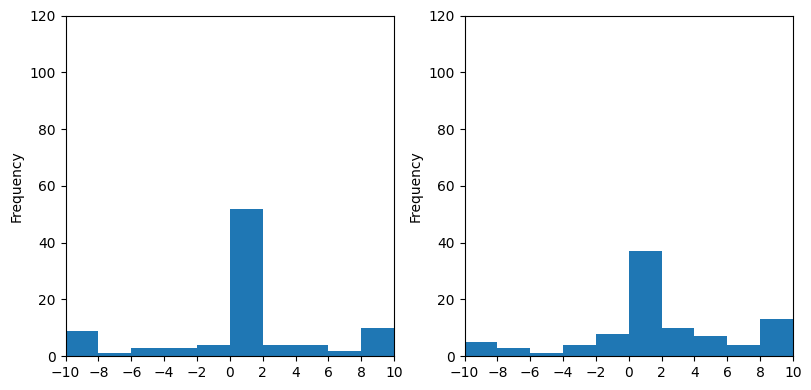

In [7]:
# show outlier distribution
fig,axs = plt.subplots(1,2)
fig.set_size_inches(8,4)
plt.tight_layout(w_pad=2)

df_outlier_count = df_outliers_consol.set_index(ftr_year_pref_muni).reset_index()
df_outlier_count = df_outlier_count.groupby(ftr_pref_muni)[pv_types].sum()
df_outlier_count = df_outlier_count[~(df_outlier_count.sum(axis=1)==0)]

df_plot = df_outlier_count.copy()
df_plot.index = range(len(df_plot))
df_plot['PV_R'].plot(kind='hist', ax=axs[0])
df_plot['PV_S'].plot(kind='hist', ax=axs[1])


for ax in axs:
	ax.set_ylim(0, 120)
	ax.set_xlim(-10, 10)
	ax.set_xticks(range(-10, 11, 2))

In [8]:
# calculate municipality with at least 1 outlier

df_temp = df_outliers_consol.groupby(ftr_pref_muni)[pv_types].sum()
df_temp = df_temp[~(df_temp.sum(axis=1)==0)]
df_outlier_a1 = df_temp.copy()
print(len(df_outlier_a1), 'Municipality with at least 1 outlier')

# calculate extreme cases 
outlier_limits = {"PV_R": (-7, 7), "PV_S": (-7, 7)}
df_filters = []
for pv_type in ["PV_R", "PV_S"]:
    df_filters.append(
        ~df_outlier_a1[pv_type].between(*outlier_limits[pv_type]).to_frame(pv_type)
    )
df_filters = pd.concat(df_filters, axis=1)
df_outlier_extremes = df_outlier_a1[df_filters.apply(any, axis=1)]
print(len(df_outlier_extremes), ' Municipality with extreme outlier')

# calculate new dfs: ex = extreme; a1 = at least 1
pv_param_no_outliers_a1 = pv_params[~(pv_params[ftr_pref_muni].apply(tuple, axis=1).isin(df_outlier_a1.index))]
df_no_outlier_a1 = build_df_for_analysis(pv_param_no_outliers_a1)

pv_param_no_outliers = pv_params[~(pv_params[ftr_pref_muni].apply(tuple, axis=1).isin(df_outlier_extremes.index))]
df_no_outlier_ex = build_df_for_analysis(pv_param_no_outliers)


92 Municipality with at least 1 outlier
33  Municipality with extreme outlier


## Re-run Model for All Outliers

In [9]:
# run the RFR again without the outliers

all_models_r2 = dict()
all_results_r2 = dict()

for var_dv in pv_types:
	# run the regression
	vars_iv = ["demand", "land_avail", "taxable_income", "LV", "SPR", "pv_out"]
	model = RandomForestRegressor(random_state=58, n_jobs=16, n_estimators=100)
	result_yearly, output_models, _ = regression_analysis_yearly(
				df_no_outlier_a1, vars_iv, var_dv, model
			)
	all_models_r2[var_dv] = output_models
	all_results_r2[var_dv] = result_yearly

for var_dv in pv_types:
	display(all_results_r2[var_dv].round(4))

,year,r2,mae,mse,rmse,demand,land_avail,taxable_income,LV,SPR,pv_out
0,2014,0.8905,0.0157,0.0011,0.0335,0.2803,0.1518,0.4858,0.0157,0.0435,0.0227
1,2015,0.8941,0.0156,0.0011,0.0331,0.2759,0.1536,0.4949,0.0173,0.0350,0.0233
2,2016,0.9017,0.0153,0.0010,0.0320,0.2761,0.1525,0.5013,0.0195,0.0276,0.0231
3,2017,0.9042,0.0154,0.0010,0.0317,0.3002,0.1553,0.4801,0.0187,0.0235,0.0221
4,2018,0.9090,0.0149,0.0010,0.0310,0.2952,0.1545,0.4849,0.0189,0.0243,0.0221
5,2019,0.9185,0.0143,0.0009,0.0295,0.2973,0.1530,0.4883,0.0173,0.0208,0.0233
6,2020,0.9212,0.0143,0.0008,0.0290,0.2947,0.1511,0.4943,0.0180,0.0214,0.0206
7,2021,0.9173,0.0143,0.0009,0.0297,0.2904,0.1467,0.5028,0.0181,0.0190,0.0231
8,2022,0.9226,0.0141,0.0008,0.0288,0.2978,0.1482,0.4980,0.0166,0.0183,0.0211
9,2023,0.9196,0.0143,0.0009,0.0295,0.2869,0.1427,0.5136,0.0169,0.0174,0.0226


,year,r2,mae,mse,rmse,demand,land_avail,taxable_income,LV,SPR,pv_out
0,2014,0.8146,0.0233,0.0015,0.0383,0.3990,0.2259,0.1122,0.0521,0.1661,0.0446
1,2015,0.7957,0.0241,0.0015,0.0392,0.3820,0.2533,0.1105,0.0671,0.1322,0.0549
2,2016,0.7659,0.0262,0.0018,0.0422,0.3894,0.2596,0.1147,0.0720,0.0958,0.0685
3,2017,0.7403,0.0273,0.0020,0.0444,0.3795,0.2621,0.1199,0.0707,0.0828,0.0850
4,2018,0.7453,0.0274,0.0019,0.0438,0.3645,0.2629,0.1244,0.0739,0.0820,0.0924
5,2019,0.7444,0.0275,0.0019,0.0437,0.3500,0.2666,0.1296,0.0835,0.0638,0.1064
6,2020,0.7390,0.0278,0.0020,0.0443,0.3378,0.2751,0.1219,0.0866,0.0771,0.1015
7,2021,0.7024,0.0293,0.0023,0.0475,0.3312,0.2785,0.1243,0.0866,0.0657,0.1137
8,2022,0.6856,0.0301,0.0024,0.0493,0.3233,0.2774,0.1278,0.0910,0.0680,0.1125
9,2023,0.6816,0.0301,0.0025,0.0500,0.3114,0.2768,0.1360,0.0958,0.0666,0.1135


## Re-run Model for Extreme Outliers

In [10]:
# run the RFR again without the outliers
all_models_r3 = dict()
all_results_r3 = dict()

for var_dv in pv_types:
    vars_iv = ["demand", "land_avail", "taxable_income", "LV", "SPR", "pv_out"]
    model = RandomForestRegressor(random_state=58, n_jobs=16, n_estimators=100)
    result_yearly, output_models, _ = regression_analysis_yearly(
        df_no_outlier_ex, vars_iv, var_dv, model
    )
    all_models_r3[var_dv] = output_models
    all_results_r3[var_dv] = result_yearly

for var_dv in pv_types:
    display(all_results_r3[var_dv].round(4).rename(columns=vars_iv_rename_cols))

,year,r2,mae,mse,rmse,DEMAND,LANDAV,TAXIN,LANDVL,PENERT,PVOUT
0,2014,0.8836,0.0165,0.0012,0.0346,0.5829,0.1001,0.2231,0.0259,0.0478,0.0202
1,2015,0.8938,0.0163,0.0011,0.0327,0.5866,0.1013,0.2292,0.0215,0.0403,0.0211
2,2016,0.8967,0.0164,0.0010,0.0320,0.5842,0.1114,0.2338,0.0199,0.0323,0.0183
3,2017,0.9033,0.0163,0.0010,0.0309,0.5899,0.1140,0.2283,0.0185,0.0303,0.0190
4,2018,0.9052,0.0160,0.0009,0.0305,0.5993,0.1127,0.2212,0.0168,0.0312,0.0188
5,2019,0.9111,0.0156,0.0009,0.0294,0.5880,0.1201,0.2291,0.0182,0.0249,0.0197
6,2020,0.9236,0.0149,0.0007,0.0273,0.5893,0.1154,0.2308,0.0195,0.0272,0.0177
7,2021,0.9263,0.0145,0.0007,0.0267,0.5920,0.1133,0.2322,0.0180,0.0245,0.0200
8,2022,0.9278,0.0145,0.0007,0.0264,0.5927,0.1122,0.2314,0.0201,0.0238,0.0198
9,2023,0.9296,0.0142,0.0007,0.0261,0.5845,0.1088,0.2490,0.0205,0.0193,0.0179


,year,r2,mae,mse,rmse,DEMAND,LANDAV,TAXIN,LANDVL,PENERT,PVOUT
0,2014,0.8119,0.0222,0.0016,0.0394,0.4206,0.1952,0.1211,0.0650,0.1521,0.0461
1,2015,0.7679,0.0252,0.0019,0.0441,0.4301,0.2280,0.1036,0.0726,0.1141,0.0516
2,2016,0.7711,0.0254,0.0019,0.0438,0.4389,0.2427,0.0873,0.0807,0.0930,0.0574
3,2017,0.7426,0.0270,0.0022,0.0464,0.4279,0.2504,0.0948,0.0825,0.0704,0.0741
4,2018,0.7316,0.0277,0.0022,0.0471,0.4180,0.2504,0.0919,0.0909,0.0710,0.0778
5,2019,0.7064,0.0287,0.0024,0.0489,0.4127,0.2564,0.0885,0.1018,0.0565,0.0842
6,2020,0.7091,0.0287,0.0024,0.0486,0.4046,0.2591,0.0843,0.1058,0.0623,0.0839
7,2021,0.6835,0.0298,0.0026,0.0506,0.3934,0.2626,0.0820,0.1157,0.0586,0.0877
8,2022,0.6705,0.0303,0.0027,0.0519,0.3895,0.2655,0.0761,0.1167,0.0606,0.0916
9,2023,0.6709,0.0301,0.0027,0.0520,0.3811,0.2657,0.0830,0.1188,0.0593,0.0921


In [11]:
# consolidate information about the extreme outliers for analysis
year = 2023
cols_int = ["demand", "land_avail", "pv_out", "taxable_income", "LV"]
cols_percent = ['SPR', 'PV_R', 'PV_S', 'PV_A',
       f'PV_R_{year}_pred', f'PV_S_{year}_pred']

outliers_index = df_outlier_extremes.index.to_list()

df_temp2 = df_predictions.filter(regex=rf"^.*_{year}$")
df_temp2.columns = [c+'_pred' for c in df_temp2.columns]
df_temp2 = df_temp2[df_temp2.index.isin(outliers_index)]

df_temp3 = df_outlier_extremes.copy()
df_temp3.columns = [c+'_out' for c in df_temp3.columns]

df_temp = df[df['year']==year]
df_temp = df_temp[df_temp[ftr_pref_muni].apply(tuple, axis=1).isin(outliers_index)]
df_temp = pd.concat([df_temp.set_index(ftr_pref_muni), df_temp2, df_temp3], axis=1).reset_index()
df_temp['pref_en'] = df_temp['pref'].map(prefecture_dict_jp_to_en)
df_temp['muni_en'] = df_temp['muni'].map(japanadmin_muni_all_jp_to_en)

df_temp['taxable_income'] = df_temp['taxable_income'].div(1_000)
df_temp[cols_int] = df_temp[cols_int].applymap(int)
df_temp[cols_percent] = df_temp[cols_percent].applymap(lambda x: round(x,4))

outlier_summary = df_temp.copy()
outlier_summary.to_csv(os.path.join(PY_FILE_LOC, "data", "pv_growth_outlier.csv"), index=False )
display_col = ['pref_en', 'muni_en'] + list(outlier_summary.columns[2:-2])
outlier_summary=outlier_summary[display_col]
outlier_summary.index = range(1, len(outlier_summary)+1)
outlier_summary


,pref_en,muni_en,year,demand,land_avail,taxable_income,pv_out,LV,SPR,PV_R,PV_S,PV_M,PV_U,PV_A,PV_R_2023_pred,PV_S_2023_pred,PV_R_out,PV_S_out
1,Hokkaido,Sapporo-shi,2023,8568474,27377,3056638,1330,71278,0.1045,0.3670,0.0649,0.109839,0.042618,0.1239,0.4664,0.1474,-10.0,-8.0
2,Aomori,Hirosaki-shi,2023,929750,12370,203233,1214,22765,0.1361,0.0453,0.0183,0.019879,0.008768,0.0202,0.0949,0.1069,0.0,-9.0
3,Iwate,Kitakami-shi,2023,2322572,8780,137413,1164,29248,0.1361,0.0973,0.0339,0.057779,0.061473,0.0612,0.1368,0.1496,0.0,-10.0
4,Akita,Akita-shi,2023,2963334,15303,436951,1226,31819,0.1361,0.1144,0.0440,0.054753,0.123899,0.0915,0.2002,0.1800,-10.0,-10.0
5,Ibaraki,Kamisu-shi,2023,1732147,7450,157035,1284,20089,0.0923,0.1405,0.4056,0.378095,0.251365,0.2867,0.1536,0.2127,0.0,9.0
6,Tochigi,Utsunomiya-shi,2023,3479737,14066,918716,1206,53406,0.0923,0.6861,0.5187,0.278082,0.498634,0.5095,0.6094,0.4546,9.0,0.0
7,Tochigi,Sano-shi,2023,903593,6949,169487,1228,29609,0.0923,0.1662,0.4287,0.360662,0.398123,0.3534,0.1370,0.2580,0.0,9.0
8,Gunma,Maebashi-shi,2023,2006622,9263,541886,1242,49504,0.0923,0.4523,0.7615,0.786084,0.146453,0.4588,0.4151,0.5953,0.0,9.0
9,Gunma,Isesaki-shi,2023,1703313,5206,316847,1223,36709,0.0923,0.3296,0.5428,0.552787,0.080478,0.3179,0.2372,0.1661,7.0,10.0
10,Gunma,Ota-shi,2023,2184175,5632,352793,1223,35385,0.0923,0.3939,0.4888,0.762771,0.183758,0.3889,0.3200,0.3719,3.0,10.0
